# Network Security Assignment
20185141 KwonSoon Yong
<!-- [참조](https://www.kaggle.com/code/adepvenugopal/network-datasets) -->

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# from scapy.all import *
# from pcapng import FileScanner
import networkx as nx
from mpl_toolkits.mplot3d import axes3d


import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import Sequential
import random
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
from torch.utils.data import Dataset ,DataLoader
from torchvision import transforms

import sklearn
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed(42)
from tqdm.auto import trange,tqdm

In [2]:
# !pip install scapy
# !pip install openpyxl

# WireShark의 패킷 분석 및 Preprocessing 절차

## clumns종류
>wireshark를 통해서 뽑아낸 column의 종류에 대해서 가볍게 보면, 다음과 같은 정보가 있다. 
'Time', 'Source', 'Source Port', 'Source Port.1', 'Destination',  
'Destination Port', 'Destination Port.1', 'Protocol', 'Length', 'Flags',  
'Sequence Number', 'Acknowledgment Number', 'Window', 'Type',  
'Time to Live', 'Total Length', 'Code', 'Length.1', 'Info'],  

### Time packet탐지 시간 
> packet을 wireshark로 탐지하기 시작한 시간부터 종료 시간까지 다만 총 5개의 wireshark 패킷을 합친 것이므로, time에 따로 전처리가 필요함

### Source 보내는 컴퓨터 ipv4 가끔 mac 주소로 되어있는 데이터도 있었음 
>.으로 되어있는데 어떻게 처리해야할지 고민, 외부 IP 내부 IP로 나누는게 좋을지? , 일단 만약 같은 IP가 대량의 ICMP, TCP, Protocol을 다양한 port로 보내면 이상탐지
> +UDP, TCP의 Source port가 따로 되어있어서 합치는 작업이 필요함 
### Destination 목적지로 하는 ivc4
>Source랑 묶어서 사용하는게 좋을듯, ex Source -> Destination을 탐지한다던가 

### Protocol
Protocol별로 info를 나눌 규칙이 필요함   
1.tcp의 경우 >로 split한다음 Source의 port와 Destination의 port를 분리   
2.UDP의 경우 열리면 응답 없고, 닫혀 있으면 ICMP UNreachable을 계속 보냄 

### Length
>이건 일정 시간동안 Length가 긴 패킷이 계속해서 들어온다면 DDos로 판단할 수 있을 것 같다. 

### Info
>제일 중요한데, 이를 encoding하는 부분이 오래 걸릴듯 

### type
>ICMP에서 사용 
> 0: (Echo (ping) reply)
> 8: (Echo (ping) request)
> 13: (Timestamp request)
> 3: Destination unreachable
### flags
> 16비트로 되어있음   
> 0x014 (RST,ACK)  
> 0x002 : SYN  
> 0x0c2 :(SYN, ECE , CWR)  
> 0x001 : FIN  
> 0x012 : (SYN,ACK)  
> 0x010 : ACK  
> 0x004 : RST  
> 0x052 :(SYN, ACK, ECN)  

### TTL

# Source , Destination을 비교하는 방법은 Gateway인 것 같다. 
>크게 4가지로 분류해보자. 
>x.x.x.1 x가 모두 같다면 같은 네트워크 상에서 들어온 network
> 첫번째 x가 다르다면 다른 외부로 부터 들어온 network 
> 

In [3]:
path = "./Network_attack/"

In [4]:
anomaly_path = [path+'fin_scan.csv',path+'tcp_half_open_scan.csv',path+'tcp_syn_scan.csv',path+'udp_flooding.csv',path+'udp_scan.csv']

In [5]:
anomaly_path

['./Network_attack/fin_scan.csv',
 './Network_attack/tcp_half_open_scan.csv',
 './Network_attack/tcp_syn_scan.csv',
 './Network_attack/udp_flooding.csv',
 './Network_attack/udp_scan.csv']

In [6]:
# pd.set_option('display.max_rows', None)

# data의 생김새를 파악 
fin_scan  = pd.read_csv(anomaly_path[0]) #스텔스 스캔  ,포트가 열린경우 응답이 없고, 닫힌 경우 RST패킷이 들어옴 
fin_scan.head()

,No.,Time,Source,Source Port,Source Port.1,Destination,Destination Port,Destination Port.1,Protocol,Length,Flags,Sequence Number,Acknowledgment Number,Window,Type,Time to Live,Total Length,Code,Length.1,Info
0,1,0.000000,10.40.219.42,NaN,NaN,10.40.201.225,NaN,NaN,ICMP,42,NaN,NaN,NaN,NaN,8.0,43,28,0.0,NaN,"Echo (ping) request id=0x94de, seq=0/0, ttl=4..."
1,2,0.000138,10.40.219.42,42325.0,NaN,10.40.201.225,443.0,NaN,TCP,58,0x002,0.0,0.0,1024.0,NaN,47,44,NaN,NaN,42325 > 443 [SYN] Seq=0 Win=1024 Len=0 MSS=1460
2,3,0.000139,10.40.219.42,42325.0,NaN,10.40.201.225,80.0,NaN,TCP,54,0x010,1.0,1.0,1024.0,NaN,38,40,NaN,NaN,42325 > 80 [ACK] Seq=1 Ack=1 Win=1024 Len=0
3,4,0.000139,10.40.219.42,NaN,NaN,10.40.201.225,NaN,NaN,ICMP,54,NaN,NaN,NaN,NaN,13.0,38,40,0.0,NaN,"Timestamp request id=0x8d05, seq=0/0, ttl=38"
4,5,0.002188,10.40.201.225,NaN,NaN,10.40.219.42,NaN,NaN,ICMP,60,NaN,NaN,NaN,NaN,0.0,63,28,0.0,NaN,"Echo (ping) reply id=0x94de, seq=0/0, ttl=6..."


In [7]:
#각 feature를 확인 
fin_scan.columns , len(fin_scan.columns)

(Index(['No.', 'Time', 'Source', 'Source Port', 'Source Port.1', 'Destination',
        'Destination Port', 'Destination Port.1', 'Protocol', 'Length', 'Flags',
        'Sequence Number', 'Acknowledgment Number', 'Window', 'Type',
        'Time to Live', 'Total Length', 'Code', 'Length.1', 'Info'],
       dtype='object'),
 20)

# data read

In [8]:
fin_scan  = pd.read_csv(anomaly_path[0]).drop("No.",axis=1) #스텔스 스캔  ,포트가 열린경우 응답이 없고, 닫힌 경우 RST패킷이 들어옴 
tcp_half  = pd.read_csv(anomaly_path[1]).drop("No.",axis=1) #스텔스 스캔 2 포트가 열린경우 Syn+ack를 요청하지만 RST보냄 닫힌 경우 RST + ACK
tcp_syn   = pd.read_csv(anomaly_path[2]).drop("No.",axis=1) # syn ack를 사용하여 scaning
udp_flood = pd.read_csv(anomaly_path[3]).drop("No.",axis=1) # Ddos공격의 일종으로, 대량의 UDP패킷을 이용하여 접속을 방해 
udp_scan  = pd.read_csv(anomaly_path[4]).drop("No.",axis=1) #포트가 닫힌 경우 ,공격 대상이 ICMP Unreachable 패킷을 보냄,열린경우 보내지 않음   

#binary classification
# fin_scan["label"]  = ["anomaly" for i in range(len(fin_scan))]
# tcp_half["label"]  = ["anomaly" for i in range(len(tcp_half))]
# tcp_syn["label"]   = ["anomaly" for i in range(len(tcp_syn))]
# udp_flood["label"] = ["anomaly" for i in range(len(udp_flood))]
# udp_scan["label"]  = ["anomaly" for i in range(len(udp_scan))]

#case 2 multi class classification
# fin_scan["label"]  = ["fin_scan" for i in range(len(fin_scan))]
# tcp_half["label"]  = ["tcp_half" for i in range(len(tcp_half))]
# tcp_syn["label"]   = ["tcp_syn" for i in range(len(tcp_syn))]
# udp_flood["label"] = ["udp_flood" for i in range(len(udp_flood))]
# udp_scan["label"]  = ["udp_scan" for i in range(len(udp_scan))]
anomaly_list = [fin_scan,tcp_half,tcp_syn,udp_flood,udp_scan]

In [9]:
sum([len(fin_scan),len(tcp_half),len(tcp_syn),len(udp_flood),len(udp_scan)])

272271

# Preprocessing을 위한 함수를 정의 preprocessing이라는 함수로 pipeline화 하여 한번에 진행 

In [10]:
def preprocessing(dataFrame):#port를 나누는 부분 
    dataFrame = port_device(dataFrame)
    dataFrame = protocol_onehot(dataFrame)
    dataFrame = flags_onehot(dataFrame)
    dataFrame = divide_TTL(dataFrame)
    dataFrame = divide_Total_length(dataFrame)
    dataFrame = label(dataFrame)   
    dataFrame = dataFrame.fillna(-1)
    dataFrame = dataFrame.drop(["index","Time","Source","Destination","Info"],axis=1) #학습에 방해가 되는 column을 지웠습니다.
    return dataFrame

def port_device(dataFrame):
    dataFrame["Source_Port"] = np.round(dataFrame["Source Port"].fillna(-0.4)+ dataFrame["Source Port.1"].fillna(-0.4)) #nan값이랑 존재하는 값이 더해졌을 때를 방지하기 위해서 0.4를 빼줌
    dataFrame["Destination_Port"] = np.round(dataFrame["Destination Port"].fillna(-0.4)+ dataFrame["Destination Port.1"].fillna(-0.4)) #nan값이랑 존재하는 값이 더해졌을 때를 방지하기 위해서 0.4를 빼줌
    dataFrame = dataFrame.drop(columns=["Source Port","Source Port.1"],axis=1)
    dataFrame = dataFrame.drop(columns=["Destination Port","Destination Port.1"],axis=1)
    return dataFrame
    

def protocol_onehot(data):#anomaly detection에서 주요하게 쓰이는 Protocol로만 구성
    data["top_protocol"] = "Other"
    top7 = ["TCP","UDP","ICMP","DNS","TLSv1.2","TLSv1.3","QUIC"]
    for i,protocol in enumerate(top7):
        # print(protocol,i)
        data.loc[data["Protocol"].str.contains(protocol),"top_protocol"]=f"{protocol}"
        
    data = data.drop("Protocol",axis=1)
    protocol_onehot = pd.get_dummies(data["top_protocol"])
    data = pd.concat([data,protocol_onehot],axis=1)
    data.drop("top_protocol",axis=1,inplace=True)
    return data

def flags_onehot(data):
    onehot = pd.get_dummies(data["Flags"])
    data = data.drop("Flags",axis=1)
    return pd.concat([data,onehot],axis=1)
def divide_TTL(data):
    data["RST_TTL"] = -1 
    for idx,i in enumerate(data["Time to Live"]):
        s,d = 0,0
        if type(i) ==str:
            if i.find(",")>0:
                s,d = i.split(",")
                data["RST_TTL"][idx] = d
                data["Time to Live"][idx] = s
    return data
def divide_Total_length(data):
    data["RST_Total_length"] = -1 
    for idx,i in enumerate(data["Total Length"]):
        s,d = 0,0
        if type(i) ==str:
            if i.find(",")>0:
                s,d = i.split(",")
                data["RST_Total_length"][idx] = d
                data["Total Length"][idx] = s
    return data
def label(data):
    data.loc[data["class"]=="normal","class"] = 0
    data.loc[data["class"]=="anomaly","class"] = 1
    return data

In [11]:
anomaly_df = pd.concat(anomaly_list,axis=0)
anomaly_df = anomaly_df.reset_index()
anomaly_df = anomaly_df.drop(columns="index",axis=1)
anomaly = anomaly_df.drop("Info",axis=1)
anomaly["class"] = "anomaly"

In [12]:
anomaly["Protocol"].value_counts()[:10].index

Index(['TCP', 'UDP', 'ICMP', 'DTLS', 'BFD Control', '0x5858', 'NFS', 'NTP',
       'DNS', 'RADIUS'],
      dtype='object')

In [13]:
normal = pd.read_csv('./Network_attack/only_normal.csv').drop('No.',axis=1)
normal["class"] = "normal"

In [14]:
normal

,Time,Source,Source Port,Source Port.1,Destination,Destination Port,Destination Port.1,Protocol,Length,Window,Sequence Number,Acknowledgment Number,Flags,Type,Time to Live,Total Length,Length.1,Info,class
0,0.000000,PcsCompu_db:96:6a,NaN,NaN,Broadcast,NaN,NaN,ARP,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Who has 10.0.2.1? Tell 10.0.2.7,normal
1,0.000203,RealtekU_12:35:00,NaN,NaN,PcsCompu_db:96:6a,NaN,NaN,ARP,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0.2.1 is at 52:54:00:12:35:00,normal
2,0.000207,10.0.2.7,NaN,34919.0,210.115.225.11,NaN,53.0,DNS,95,NaN,NaN,NaN,NaN,NaN,64.0,81.0,61.0,Standard query 0xb118 A content-signature-2.cd...,normal
3,0.000212,10.0.2.7,NaN,34919.0,210.115.225.11,NaN,53.0,DNS,95,NaN,NaN,NaN,NaN,NaN,64.0,81.0,61.0,Standard query 0xc506 AAAA content-signature-2...,normal
4,0.106110,210.115.225.11,NaN,53.0,10.0.2.7,NaN,34919.0,DNS,249,NaN,NaN,NaN,NaN,NaN,255.0,235.0,215.0,Standard query response 0xb118 A content-signa...,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124208,1352.250301,10.0.2.7,47984.0,NaN,27.0.237.155,443.0,NaN,TCP,54,65535.0,12593.0,2562519.0,0x010,NaN,64.0,40.0,NaN,47984 > 443 [ACK] Seq=12593 Ack=2562519 Win=...,normal
124209,1354.548231,10.0.2.7,51364.0,NaN,172.217.25.163,80.0,NaN,TCP,54,63791.0,833.0,1404.0,0x010,NaN,64.0,40.0,NaN,[TCP Keep-Alive] 51364 > 80 [ACK] Seq=833 Ac...,normal
124210,1354.548366,172.217.25.163,80.0,NaN,10.0.2.7,51364.0,NaN,TCP,60,31935.0,1404.0,834.0,0x010,NaN,255.0,40.0,NaN,[TCP Keep-Alive ACK] 80 > 51364 [ACK] Seq=14...,normal
124211,1358.644182,10.0.2.7,52436.0,NaN,117.18.237.29,80.0,NaN,TCP,54,63920.0,414.0,800.0,0x010,NaN,64.0,40.0,NaN,[TCP Keep-Alive] 52436 > 80 [ACK] Seq=414 Ac...,normal


# Normal 데이터와 Anomaly 데이터를 묶어서 preprocessing을 진행
## 어차피 학습할때는 shuffle을 사용하므로 그냥 concat을 해도 상관 없음 

In [15]:
dataset = pd.concat([anomaly,normal])
dataset = dataset.reset_index()

dataset = preprocessing(dataset)

C:\Users\yks\AppData\Local\Temp\ipykernel_69840\3493943813.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["RST_TTL"][idx] = d
C:\Users\yks\AppData\Local\Temp\ipykernel_69840\3493943813.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Time to Live"][idx] = s
C:\Users\yks\AppData\Local\Temp\ipykernel_69840\3493943813.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["RST_Total_length"][idx] = d
C:\Users\yks\A

In [16]:
dataset

,Length,Sequence Number,Acknowledgment Number,Window,Type,Time to Live,Total Length,Code,Length.1,class,...,0x010,0x011,0x012,0x014,0x018,0x019,0x052,0x0c2,RST_TTL,RST_Total_length
0,42,-1.0,-1.0,-1.0,8.0,43,28,0.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
1,58,0.0,0.0,1024.0,-1.0,47,44,-1.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
2,54,1.0,1.0,1024.0,-1.0,38,40,-1.0,-1.0,1,...,1,0,0,0,0,0,0,0,-1,-1
3,54,-1.0,-1.0,-1.0,13.0,38,40,0.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
4,60,-1.0,-1.0,-1.0,0.0,63,28,0.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396479,54,12593.0,2562519.0,65535.0,-1.0,64.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1
396480,54,833.0,1404.0,63791.0,-1.0,64.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1
396481,60,1404.0,834.0,31935.0,-1.0,255.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1
396482,54,414.0,800.0,63920.0,-1.0,64.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1


In [17]:
anomaly["Protocol"]

0         ICMP
1          TCP
2          TCP
3         ICMP
4         ICMP
          ... 
272266    ICMP
272267     UDP
272268    ICMP
272269     UDP
272270    ICMP
Name: Protocol, Length: 272271, dtype: object

In [18]:
anomaly[["Total Length"]]

,Total Length
0,28
1,44
2,40
3,40
4,28
...,...
272266,"56,28"
272267,28
272268,"56,28"
272269,28


In [19]:
dataset[["RST_Total_length","Total Length"]]

,RST_Total_length,Total Length
0,-1,28
1,-1,44
2,-1,40
3,-1,40
4,-1,28
...,...,...
396479,-1,40.0
396480,-1,40.0
396481,-1,40.0
396482,-1,40.0


In [20]:
dataset

,Length,Sequence Number,Acknowledgment Number,Window,Type,Time to Live,Total Length,Code,Length.1,class,...,0x010,0x011,0x012,0x014,0x018,0x019,0x052,0x0c2,RST_TTL,RST_Total_length
0,42,-1.0,-1.0,-1.0,8.0,43,28,0.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
1,58,0.0,0.0,1024.0,-1.0,47,44,-1.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
2,54,1.0,1.0,1024.0,-1.0,38,40,-1.0,-1.0,1,...,1,0,0,0,0,0,0,0,-1,-1
3,54,-1.0,-1.0,-1.0,13.0,38,40,0.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
4,60,-1.0,-1.0,-1.0,0.0,63,28,0.0,-1.0,1,...,0,0,0,0,0,0,0,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396479,54,12593.0,2562519.0,65535.0,-1.0,64.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1
396480,54,833.0,1404.0,63791.0,-1.0,64.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1
396481,60,1404.0,834.0,31935.0,-1.0,255.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1
396482,54,414.0,800.0,63920.0,-1.0,64.0,40.0,-1.0,-1.0,0,...,1,0,0,0,0,0,0,0,-1,-1


In [21]:
dataset.columns

Index(['Length', 'Sequence Number', 'Acknowledgment Number', 'Window', 'Type',
       'Time to Live', 'Total Length', 'Code', 'Length.1', 'class',
       'Source_Port', 'Destination_Port', 'DNS', 'ICMP', 'Other', 'QUIC',
       'TCP', 'TLSv1.2', 'TLSv1.3', 'UDP', '0x001', '0x002', '0x004', '0x010',
       '0x011', '0x012', '0x014', '0x018', '0x019', '0x052', '0x0c2',
       'RST_TTL', 'RST_Total_length'],
      dtype='object')

## class를 맨 뒤에 가도록 변경

In [22]:
dataset = pd.DataFrame(dataset,columns=['Length', 'Sequence Number', 'Acknowledgment Number', 'Window', 'Type',
       'Time to Live', 'Total Length', 'Code', 'Length.1', 
       'Source_Port', 'Destination_Port', 'DNS', 'ICMP', 'Other', 'QUIC',
       'TCP', 'TLSv1.2', 'TLSv1.3', 'UDP', '0x001', '0x002', '0x004', '0x010',
       '0x011', '0x012', '0x014', '0x018', '0x019', '0x052', '0x0c2',
       'RST_TTL', 'RST_Total_length','class'])

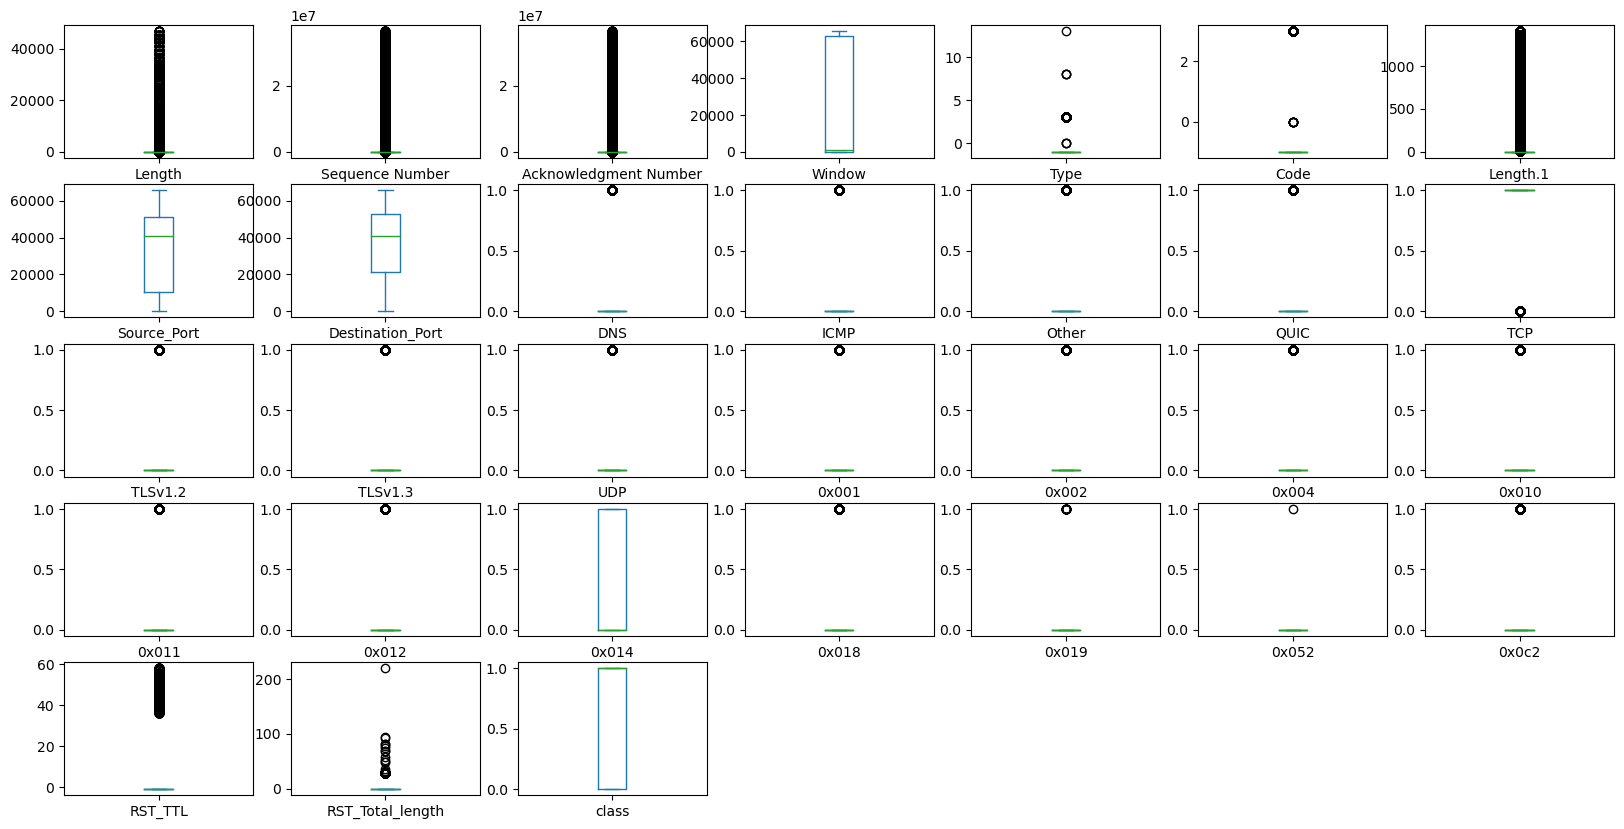

In [23]:
dataset.plot(kind='box',subplots=True,layout=(5,7),figsize=(20, 10))
plt.show()

In [24]:
from sklearn.decomposition import PCA

# 학습을 진행하기 전 Train, Test split

In [25]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset["class"])
train,valid= train_test_split(train, test_size=0.2, random_state=42, stratify=train["class"])


x_test = test.drop("class",axis=1)
y_test = test["class"].copy()
x_train= train.drop('class',axis=1)
y_train= train['class'].copy()


x_train,x_val, y_train,y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42,stratify=y_train)

#to numpy
x_test = np.array(x_test,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)
x_train = np.array(x_train,dtype=np.float32)
x_val = np.array(x_val,dtype=np.float32)
y_train = np.array(y_train,dtype=np.float32)
y_val = np.array(y_val,dtype=np.float32)

In [26]:
# dataset.to_csv('./dataset.csv')

In [27]:
def visualize_pca(data,label,sample_num=300,normalize=False):
    pca = PCA(n_components=2) # 2 차원으로 축소 
    components = pca.fit_transform(data) #data에 대해서 PCA를 진행 
    if normalize: 
        MEAN = np.mean(components,axis=1).reshape(-1,1)
        STD  = np.std(components,axis=1).reshape(-1,1)
        components = (components-MEAN)/STD
    plt.figure(figsize=(6,6))
    
    normal_x  = []
    normal_y  = []
    anomaly_x = []
    anomaly_y = []
    for idx,i in enumerate(label):
        if i ==1:
            normal_x.append(components[idx][0])
            normal_y.append(components[idx][1])
        else:
            anomaly_x.append(components[idx][0])
            anomaly_y.append(components[idx][1])
    plt.scatter(normal_x[:sample_num], normal_y[:sample_num], color="red", label="normal")
    plt.scatter(anomaly_x[:sample_num-200], anomaly_y[:sample_num-200], color="blue", label="anomaly")
    plt.legend()
    plt.show()
    
def visualize_3d(data,label,sample_num=300,normalize=False): # 3d
    pca_3d =  PCA(n_components=3)    
    components2 = pca_3d.fit_transform(data)
    if normalize:
        MEAN = np.mean(components,axis=1).reshape(-1,1)
        STD  = np.std(components,axis=1).reshape(-1,1)
        components = (components-MEAN)/STD
    normal_x  = []
    normal_y  = []
    normal_z  = []
    anomaly_x = []
    anomaly_y = []
    anomaly_z = []
    
    for idx,i in enumerate(label):
        if i ==1:
            normal_x.append(components2[idx][0])
            normal_y.append(components2[idx][1])
            normal_z.append(components2[idx][2])
            
        else:
            anomaly_x.append(components2[idx][0])
            anomaly_y.append(components2[idx][1])
            anomaly_z.append(components2[idx][2])
            
    fig, ax= plt.subplots(1,1, subplot_kw={"projection":"3d"})
    fontlabel = {"fontsize":"large", "color":"gray", "fontweight":"bold"}

    # for idx,ax in enumerate(axs):

    ax.scatter(normal_x[:sample_num], normal_y[:sample_num],normal_z[:sample_num], color="red", label="normal")
    ax.scatter(anomaly_x[:sample_num], anomaly_y[:sample_num],anomaly_z[:sample_num],color="blue", label="anomaly")
    ax.view_init(elev=30,azim=20)
    ax.legend()
    plt.show()    

In [28]:
dataset2 = np.array(dataset,dtype= np.float32).copy()

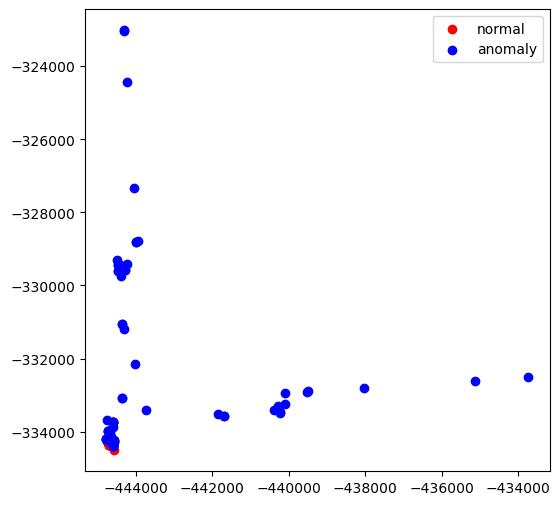

In [29]:
visualize_pca(dataset2[:,:-1],dataset2[:,-1])

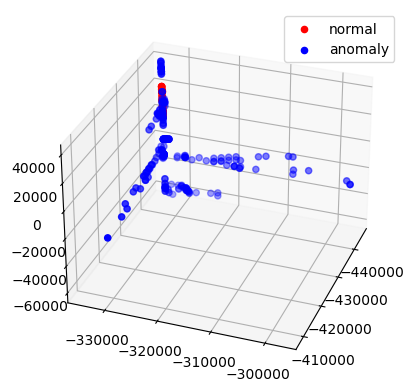

In [30]:
visualize_3d(dataset2[:,:-1],dataset2[:,-1])

In [31]:

class customDataset(Dataset):
    def __init__(self,data,label=None,transform= None):
        super().__init__()
        self.data = torch.tensor(data,dtype =torch.float32)
        self.label = torch.tensor(label,dtype =torch.float32)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        
        if self.label is not None:
            return self.data[index],self.label[index]
        else:
            return self.data[index]
def linblock(in_dim,out_dim):
    return nn.Sequential(nn.Linear(in_dim,out_dim,bias=False),
                        nn.BatchNorm1d(out_dim),
                        nn.ReLU())
def train_epoch(model, loader, device, criterion, optimizer,display=True,amp = True):
    model.train()   # 모델 train 모드로 바꾸기
    train_loss = []
    train_acc  = []
    # scaler = GradScaler()
    if display:
        bar = tqdm(loader)
    else:
        bar = loader
        
    for i, (data, target) in enumerate(bar):

        optimizer.zero_grad()  # set zero grad about optimizer 
        data, target = data.to(device), target.to(device)  # use gpu if we can use GPU
        
        # with autocast():
        logits = model(data)              # float32 -> float 16 
        loss = criterion(logits.squeeze(), target)  # 
            
        # scaler.scale(loss).backward()                   # 3. backward pass
        loss.backward()
        # scaler.step(optimizer)                  # 4. parameter update with gradient descent
        optimizer.step()                  # 4. parameter update with gradient descent
        # scaler.update()
        
        train_loss.append(loss.detach().cpu().numpy())
        
        output = logits.detach().squeeze() # binary class이기 때문에 0.5보다 크면 anomaly라고 분류
        output[output>=0.5]=1
        output[output<0.5]=0    
        equals = output == target.reshape(output.shape)
        train_acc.append(torch.mean(equals.type(torch.float)).detach().cpu())
        
        if display:bar.set_description('Train Loss: {:.5f} \tAcc: {:.5f}'.format(np.mean(train_loss),(np.mean(train_acc))))
    train_loss = np.mean(train_loss)  # mean loss of one epoch
    train_acc  = np.mean(train_acc)   # mean acc  of one epohc
    return train_loss ,train_acc     
def val_epoch(model, loader, device, criterion,display = False):

    model.eval()  # not train 
    val_loss = []
    val_acc  = []
    LOGITS = []
    TARGETS = []
    if display:bar = tqdm(loader)
    else:bar = loader
    with torch.no_grad(): # validation step is not used gradient 
        for (data, target) in bar:
            
            data, target = data.to(device), target.to(device) # 지정한 device로 데이터 옮기기
            # logits = model(data)                              # 1. forward pass
            # with autocast():
            logits = model(data)              # float32 -> float 16 
            loss = criterion(logits.squeeze(), target)  # 
            # probs = logits.softmax(dim =1)                         # 다중분류 -> 각 클래스일 확률을 전체 1로 두고 계산하기
            output = logits.detach().squeeze()
            output[output>=0.5]=1
            output[output<0.5]=0  
            LOGITS.append(output.detach().cpu())
            # PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            # loss = criterion(logits, target) # 2. loss 계산
            # ps = F.softmax(logits,dim=1)
            # top_p,top_class = ps.topk(1,dim=1)
  
            equals = output==target.reshape(output.shape)

            
            val_loss.append(loss.detach().cpu().numpy())
            val_acc.append(torch.mean(equals.type(torch.float)).detach().cpu())
            
            if display:bar.set_description('Valid Loss: {:.5f} \tAcc: {:.5f}'.format(np.mean(val_loss),(np.mean(val_acc))))    
            
    #한번에 계산하는 방법
    LOGITS = torch.cat(LOGITS).numpy()
    # PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()
    # val_acc = (PROBS.argmax(1) == TARGETS).mean()
    val_acc = np.mean(val_acc)
    # accuracy : 정확도
    val_loss = np.mean(val_loss)
    # val_acc = np.mean(val_acc)
    return val_loss, val_acc ,LOGITS,TARGETS

In [32]:
train_dataset = customDataset(x_train,y_train)
valid_dataset = customDataset(x_val,y_val)
batch_size = 512
train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
valid_loader = DataLoader(valid_dataset,batch_size = batch_size,shuffle = True)
test_dataset  = customDataset(x_test,y_test)
test_loader = DataLoader(test_dataset,batch_size = batch_size,shuffle = True)
device = 'cuda'


In [33]:
model = nn.Sequential(linblock(32,256),
                     linblock(256,512),
                     linblock(512,1024),
                     linblock(1024,512),
                     linblock(512,256),
                     nn.Linear(256,1),
                     nn.Sigmoid())
model.to(device)
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(),lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

In [34]:
tloss = []
vloss = []
tacc = []
vacc = []
for i in tqdm(range(10)):
    train_loss,train_acc = train_epoch(model.to(device), train_loader, device, criterion, optimizer,display=True,amp = False)
    valid_loss ,valid_acc,_,_ = val_epoch(model,valid_loader, device, criterion,display = True)
    tloss.append(train_loss)
    vloss.append(valid_loss)
    tacc.append(train_acc)
    vacc.append(valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

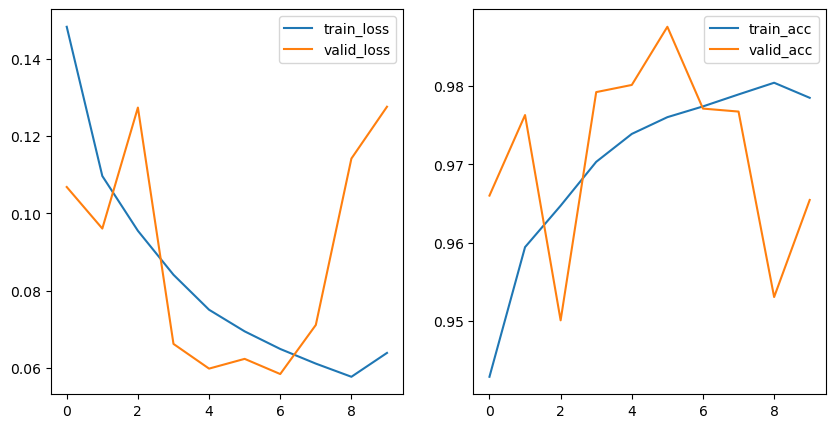

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(tloss,label = "train_loss")
plt.plot(vloss,label = "valid_loss")
plt.legend()
plt.subplot(122)
plt.plot(tacc,label = "train_acc")
plt.plot(vacc,label = "valid_acc")
plt.legend()

plt.show()

In [35]:
torch.save(model.state_dict(),"./model/fully_connected.pt")

In [36]:
model.load_state_dict(torch.load("./model/fully_connected.pt"))

<All keys matched successfully>

In [36]:


LABEL = []
DATA = []
PREDICT =[]
for data,label in test_loader:
    data,label = data.to(device),label.to(device)
    output = model(data)
    predict = output.detach().cpu()
    predict[predict>=0.5] =1
    predict[predict<0.5]=0
    
    DATA.append(data.detach().cpu())
    LABEL.append(label.detach().cpu())
    PREDICT.append(predict)
DATA = torch.cat(DATA).numpy()
LABEL = torch.cat(LABEL).numpy()
PREDICT = torch.cat(PREDICT).numpy()

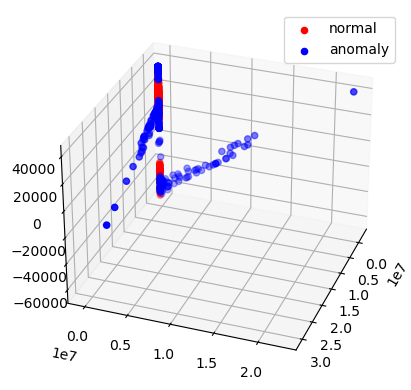

In [37]:
visualize_3d(DATA,LABEL,sample_num=300,normalize=False)

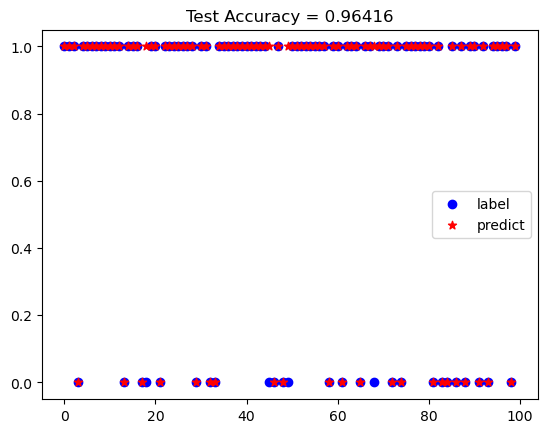

In [38]:
plt.scatter(np.arange(100),LABEL[:100],color = 'blue',label = "label")
plt.scatter(np.arange(100),PREDICT[:100],color = "red",marker='*',label = "predict")
plt.legend()
plt.title("Test Accuracy = {:.5f}".format(np.mean((PREDICT==LABEL.reshape(-1,1)))))
plt.show()

# case 2: AutoML을 사용 

## preprocessing을 진행, input은 dataframe을 입력 

In [46]:
from pycaret.regression import *
setup_clf = setup(data = train,target='class',train_size=0.7,
                  # numeric_features = ["Duration","Src Pt","Dst Pt",],
                  # Remove Perfect Collinearity=True
                  remove_perfect_collinearity=True,
                 session_id=777)

,Description,Value
0,session_id,777
1,Target,class
2,Original Data,"(253749, 33)"
3,Missing Values,False
4,Numeric Features,31
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(177624, 37)"


# 좋은 모델을 selection, 가장 좋은 성능을 내는 모델을 색칠해서 보여준다

In [58]:
#3가지 좋은 모델을 select
best_model = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0001,0.0000,0.0046,0.9999,0.0031,0.0001,5.7100
et,Extra Trees Regressor,0.0000,0.0000,0.0036,0.9999,0.0025,0.0000,3.7800
catboost,CatBoost Regressor,0.0001,0.0000,0.0029,0.9999,0.0019,0.0001,5.7580
xgboost,Extreme Gradient Boosting,0.0001,0.0000,0.0035,0.9999,0.0022,0.0001,2.7770
dt,Decision Tree Regressor,0.0000,0.0000,0.0053,0.9998,0.0036,0.0000,0.1170
lightgbm,Light Gradient Boosting Machine,0.0003,0.0001,0.0076,0.9997,0.0051,0.0002,0.3390
gbr,Gradient Boosting Regressor,0.0022,0.0002,0.0135,0.9991,0.0112,0.0011,5.3370
knn,K Neighbors Regressor,0.0005,0.0002,0.0154,0.9989,0.0109,0.0004,3.7810
ada,AdaBoost Regressor,0.0143,0.0004,0.0195,0.9982,0.0116,0.0189,1.4420
br,Bayesian Ridge,0.0084,0.0018,0.0420,0.9918,0.0297,0.0060,0.2700


# 색때문에 잘 안보여서 다시 확인

In [59]:
result = pull()
display(result)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0001,0.0000,0.0046,0.9999,0.0031,0.0001,5.710
et,Extra Trees Regressor,0.0000,0.0000,0.0036,0.9999,0.0025,0.0000,3.780
catboost,CatBoost Regressor,0.0001,0.0000,0.0029,0.9999,0.0019,0.0001,5.758
xgboost,Extreme Gradient Boosting,0.0001,0.0000,0.0035,0.9999,0.0022,0.0001,2.777
dt,Decision Tree Regressor,0.0000,0.0000,0.0053,0.9998,0.0036,0.0000,0.117
lightgbm,Light Gradient Boosting Machine,0.0003,0.0001,0.0076,0.9997,0.0051,0.0002,0.339
gbr,Gradient Boosting Regressor,0.0022,0.0002,0.0135,0.9991,0.0112,0.0011,5.337
knn,K Neighbors Regressor,0.0005,0.0002,0.0154,0.9989,0.0109,0.0004,3.781
ada,AdaBoost Regressor,0.0143,0.0004,0.0195,0.9982,0.0116,0.0189,1.442
br,Bayesian Ridge,0.0084,0.0018,0.0420,0.9918,0.0297,0.0060,0.270


In [60]:
# n_select개 만큼 좋았던 모델을 기반으로 앙상블을 진행 
blended = blend_models(estimator_list = best_model, fold = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0001,0.0000,0.0016,1.0000,0.0009,0.0001
1,0.0001,0.0000,0.0053,0.9999,0.0032,0.0001
2,0.0001,0.0000,0.0055,0.9999,0.0038,0.0001
3,0.0001,0.0000,0.0030,1.0000,0.0016,0.0001
4,0.0001,0.0000,0.0036,0.9999,0.0027,0.0001
Mean,0.0001,0.0000,0.0038,0.9999,0.0025,0.0001
Std,0.0000,0.0000,0.0015,0.0000,0.0010,0.0000


In [64]:
#ensemble된 모델을 기반으로 validation set으로 predict를 진행 
pred_holdout = predict_model(blended)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0021,1.0000,0.0013,0.0000


In [65]:
#validation에서 학습하지 않은 데이터에 대해서도 추가적으로 학습을 진행합니다
final_model = finalize_model(blended)

In [87]:
save_model(final_model, './model/automl_save')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                                                                   max_samples=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                          

In [42]:
from pycaret.regression import *

In [88]:
final_model = load_model('./model/automl_save')

Transformation Pipeline and Model Successfully Loaded


In [49]:
# 전체 데이터로 학습한 모델을 기반으로 test에 대해서 예측을 진행 
predictions = predict_model(final_model, data = test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0000,0.0000,0.0039,0.9999,0.0025,0.0000


In [50]:
test

,Length,Sequence Number,Acknowledgment Number,Window,Type,Time to Live,Total Length,Code,Length.1,Source_Port,...,0x011,0x012,0x014,0x018,0x019,0x052,0x0c2,RST_TTL,RST_Total_length,class
130422,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,44420.0,...,0,0,1,0,0,0,0,-1,-1,1
50035,60,0.0,0.0,1024.0,-1.0,51,44,-1.0,-1.0,40609.0,...,0,0,0,0,0,0,0,-1,-1,1
75857,60,0.0,0.0,1024.0,-1.0,51,44,-1.0,-1.0,40609.0,...,0,0,0,0,0,0,0,-1,-1,1
164887,78,0.0,0.0,65535.0,-1.0,254,64,-1.0,-1.0,50515.0,...,0,0,0,0,0,0,0,-1,-1,1
230818,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,31654.0,...,0,0,1,0,0,0,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42130,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,45920.0,...,0,0,1,0,0,0,0,-1,-1,1
124743,60,0.0,0.0,1024.0,-1.0,37,44,-1.0,-1.0,40609.0,...,0,0,0,0,0,0,0,-1,-1,1
172180,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,65449.0,...,0,0,1,0,0,0,0,-1,-1,1
394756,74,-1.0,-1.0,-1.0,-1.0,64.0,60.0,-1.0,40.0,32923.0,...,0,0,0,0,0,0,0,-1,-1,0


In [51]:
predictions

,Length,Sequence Number,Acknowledgment Number,Window,Type,Time to Live,Total Length,Code,Length.1,Source_Port,...,0x012,0x014,0x018,0x019,0x052,0x0c2,RST_TTL,RST_Total_length,class,Label
130422,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,44420.0,...,0,1,0,0,0,0,-1,-1,1,1.000003e+00
50035,60,0.0,0.0,1024.0,-1.0,51,44,-1.0,-1.0,40609.0,...,0,0,0,0,0,0,-1,-1,1,1.000002e+00
75857,60,0.0,0.0,1024.0,-1.0,51,44,-1.0,-1.0,40609.0,...,0,0,0,0,0,0,-1,-1,1,9.999909e-01
164887,78,0.0,0.0,65535.0,-1.0,254,64,-1.0,-1.0,50515.0,...,0,0,0,0,0,0,-1,-1,1,1.000053e+00
230818,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,31654.0,...,0,1,0,0,0,0,-1,-1,1,1.000002e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42130,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,45920.0,...,0,1,0,0,0,0,-1,-1,1,9.999985e-01
124743,60,0.0,0.0,1024.0,-1.0,37,44,-1.0,-1.0,40609.0,...,0,0,0,0,0,0,-1,-1,1,1.000104e+00
172180,54,1.0,1.0,0.0,-1.0,64,40,-1.0,-1.0,65449.0,...,0,1,0,0,0,0,-1,-1,1,1.000008e+00
394756,74,-1.0,-1.0,-1.0,-1.0,64.0,60.0,-1.0,40.0,32923.0,...,0,0,0,0,0,0,-1,-1,0,8.860698e-06


In [52]:
automl_predict = np.array(predictions["Label"])
automl_predict

array([1.00000293e+00, 1.00000233e+00, 9.99990939e-01, ...,
       1.00000751e+00, 8.86069839e-06, 1.34949980e-07])

In [53]:
#output이 float이므로 정수형으로 형변환 
automl_predict = np.round(automl_predict,2)
automl_predict

TypeError: _around_dispatcher() got an unexpected keyword argument 'dtype'

In [54]:
automl_label = np.array(predictions["class"])

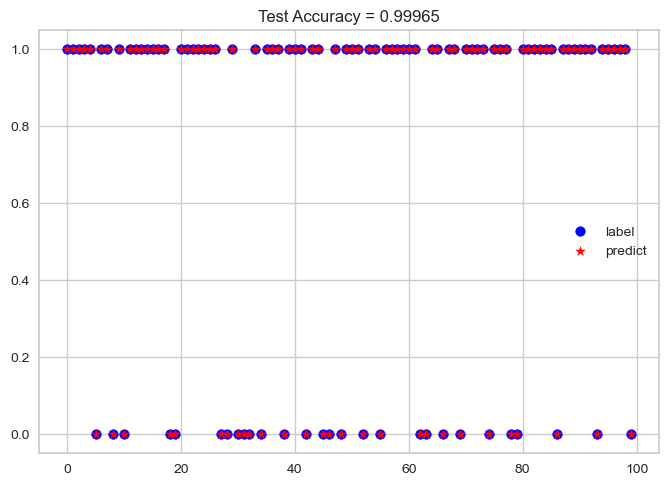

In [55]:
plt.scatter(np.arange(100),automl_label[:100],color = 'blue',label = "label")
plt.scatter(np.arange(100),automl_predict[:100],color = "red",marker='*',label = "predict")
plt.legend()
plt.title("Test Accuracy = {:.5f}".format(np.mean((automl_predict==automl_label))))
plt.show()

In [56]:
from sklearn.metrics import auc,f1_score,precision_score,recall_score

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
confusion_matrix(LABEL,PREDICT)

array([[22055,  2788],
       [   54, 54400]], dtype=int64)

In [59]:
import seaborn as sns

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [68]:
x_label = ["False Prediction", "Positive Prediction"]
y_label = ["False Class", "True Class"]

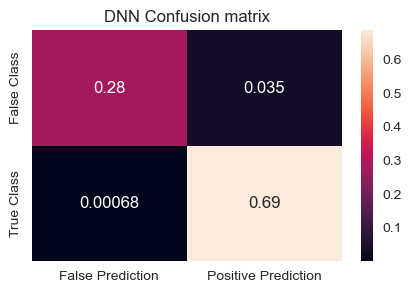

In [71]:
cm = confusion_matrix(LABEL,PREDICT)
f,ax = plt.subplots(1,1,figsize =(5,3))
sns.heatmap(cm/np.sum(cm),annot=True)
ax.set_xticklabels(x_label)
ax.set_yticklabels(y_label)
ax.set_title("DNN Confusion matrix")
plt.show()

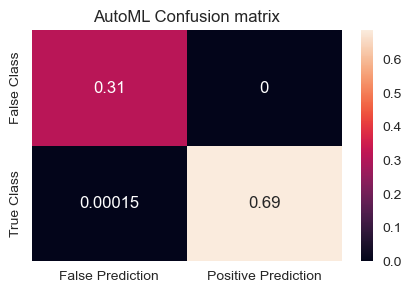

In [82]:
cm = confusion_matrix(automl_label,automl_predict.astype(np.int32))
f,ax = plt.subplots(1,1,figsize =(5,3))
sns.heatmap(cm/np.sum(cm),annot=True)
ax.set_xticklabels(x_label)
ax.set_yticklabels(y_label)
ax.set_title("AutoML Confusion matrix")
plt.show()

In [85]:
print("DNN Precision score\t{:.5f}".format(precision_score(LABEL,PREDICT)))
print("AutoML Precision score\t{:.5f}".format(precision_score(automl_label,automl_predict.astype(np.int32))))
print("DNN Recall score\t{:.5f}".format(recall_score(LABEL,PREDICT)))
print("AutoML Recall score\t{:.5f}".format(recall_score(automl_label,automl_predict.astype(np.int32))))

DNN Precision score	0.95125
AutoML Precision score	1.00000
DNN Recall score	0.99901
AutoML Recall score	0.99978
